# Can we use ML4L as a land surface model emulator?

That is, can we predict the skin temperature given only "atmospheric" inputs?

In practice this means making sure that the inputs to our network don't contain outputs of some land model. 

Here we have dropped `skt` and `t2m` but keep all the other features that we were using for lakes.

This notebook demonstrates a first rough attempt at this problem. 

The network was trained quickly, only 100 epochs,large batch sizes etc. without a focus on any hyper-param optimisations. We are also missing potentially useful features e.g. precip, clouds, humidity.

We use the familiar time-split as used in the lakes work: train 2016, validate 2017, test 2019.

In [47]:
path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/LandEmul_2016_V3/'

# Configuration

In [48]:
import json
with open(path_to_model+'configuration.json') as f:
    config=json.load(f)
    display(config['train'])
    features_used_by_model = config['train']['training_features']

{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_ML.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2017_ML.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'fal',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15',
  'sdor_v20',
  'cvl_v20',
  'lsm_v20',
  'isor_v20',
  'cvh_v20',
  'si10_v20',
  'anor_v20',
  'cl_v20',
  'dl_v20',
  'z_v20',
  'slor_v20',
  'clake_monthly_value',
  'cl_saline_max'],
 'batch_size': 10000,
 'epochs': 200,
 'number_of_hidden_layers': 4,
 'nodes_per_layer': [None, None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics':

# What are the features, physically?

I can never remember the abbreviatins/acronyms...

In [49]:
import requests

fnames = np.unique([x.split('_')[0] for x in features_used_by_model])  

r = requests.get("https://apps.ecmwf.int/codes/grib/json/").json()['parameters']

def param_name(x,r):
    try:
        d = next(item for item in r if item["param_shortName"] == x)
        name = d['param_name']
        units = d['units_name']
    except:
        #maybe naming convention is different
        name = 'Unknown'
        units = 'Unknown'
    
    return f'{x}: {name} : {units}'


for i in fnames:
    print(param_name(i,r))

alnid: Near IR albedo for diffuse radiation : (0 - 1)
alnip: Near IR albedo for direct radiation : (0 - 1)
aluvd: UV visible albedo for diffuse radiation : (0 - 1)
aluvp: UV visible albedo for direct radiation : (0 - 1)
anor: Angle of sub-gridscale orography : radians
cl: Lake cover : (0 - 1)
clake: Unknown : Unknown
cvh: High vegetation cover : (0 - 1)
cvl: Low vegetation cover : (0 - 1)
dl: Lake total depth : m
fal: Forecast albedo : (0 - 1)
isor: Anisotropy of sub-gridscale orography : ~
istl1: Ice temperature layer 1 : K
istl2: Ice temperature layer 2 : K
lsm: Land-sea mask : (0 - 1)
msl: Mean sea level pressure : Pa
sd: Snow depth water equivalent : kg m**-2
sdfor: Standard deviation of filtered subgrid orography : m
sdor: Standard deviation of orography : m
si10: Unknown : Unknown
slor: Slope of sub-gridscale orography : ~
slt: Soil type : ~
sp: Wind speed (SP) : m s**-1
tvh: Type of high vegetation : ~
tvl: Type of low vegetation : ~
u10: Unknown : Unknown
v10: Unknown : Unknown

# Training history

Number of epochs: 199
Minimum training loss: 25.352149963378906
Minimum validation loss: 24.793031692504883


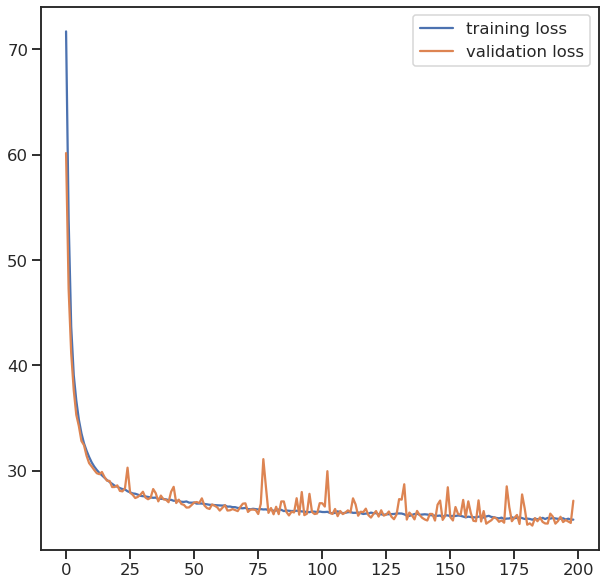

In [50]:
import numpy as np
import matplotlib.pyplot as plt
with open(path_to_model+'training_history.json') as f:
    d = json.load(f)

    training_loss = d['loss'][1:]
    validation_loss = d['val_loss'][1:]
    epochs = np.arange(len(training_loss))
    print ('Number of epochs:', len(epochs))
    print ('Minimum training loss:', min(training_loss))
    print('Minimum validation loss:', min(validation_loss))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(epochs,training_loss,label='training loss')
    plt.plot(epochs,validation_loss, label='validation loss')
    plt.legend()
        


# Predictions

In [51]:
import pandas as pd
def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
    
    
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)
    
    df['delta'] = df['ERA_predicion_error'] - df['model_predicion_error']


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())
    print ('------------------------------------ERA---------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['ERA_predicion_bias'].mean(), df['ERA_predicion_bias'].median(),df['ERA_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['ERA_predicion_error'].mean(), df['ERA_predicion_error'].median(),df['ERA_predicion_error'].std())
    print ('-------------------------------------------------------------------------------------------')

    
    return df

from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




         
def global_plot(df,z,projection,vmin,vmax,cmap,absolute_values,logscale,title,markersize,savefig):
    
    
        
       # ccrs.Robinson()
        
    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=projection)
    cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])

    #Get data
    try:
        x = df.longitude
        y = df.latitude
    except: #different sources call lat/lon different things
        x = df.longitude_ERA
        y = df.latitude_ERA

    z1 = df[z]
    if absolute_values:
        z1 = abs(z1)
        if vmin < 0:
            vmin = 0 # dont need negative vmins if plotting absolute values
    
    
    #Normalize, colorbars
    if vmin is None:
        vmin = min(z1)
    if vmax is None:
        vmax = max(z1)
        

     #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    
    
    
    
    
    
    #Scatter points
    sc = ax.scatter(x,y,transform=ccrs.PlateCarree(), #Always PlateCarree
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=16)
    cax.set_xlabel('K',fontsize=16)

    ax.set_title(title)    
    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    #ax.set_xlim(-180,180)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   
        
        
        
        
            

In [52]:
predictions = load_predictions(path_to_model)
yearly_averaged_predictions = predictions.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.88658905 1.0592346 5.150801
Mean/Median/Std prediction error: 3.929673 3.0648499 3.4459367
------------------------------------ERA---------------------------------------------------
Mean/Median/Std prediction bias: -0.4853097 -0.5901489 5.1987367
Mean/Median/Std prediction error: 3.8696697 2.973236 3.5054328
-------------------------------------------------------------------------------------------


Ok cool, all the model numbers are < all the ERA numbers!

What does this actually look like?

In [ ]:
global_plot(yearly_averaged_predictions,
            'ERA_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title='ERA prediction error',
            markersize=2,
            savefig=None)


global_plot(yearly_averaged_predictions,
            'model_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title='Model prediction error',
            markersize=2,
            savefig=None)



In [ ]:
global_plot(yearly_averaged_predictions,
            'delta',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=-5,vmax=+5,
            cmap=plt.cm.coolwarm,
            absolute_values = False,
            logscale=False,
            title='Model prediction error',
            markersize=2,
            savefig=None)

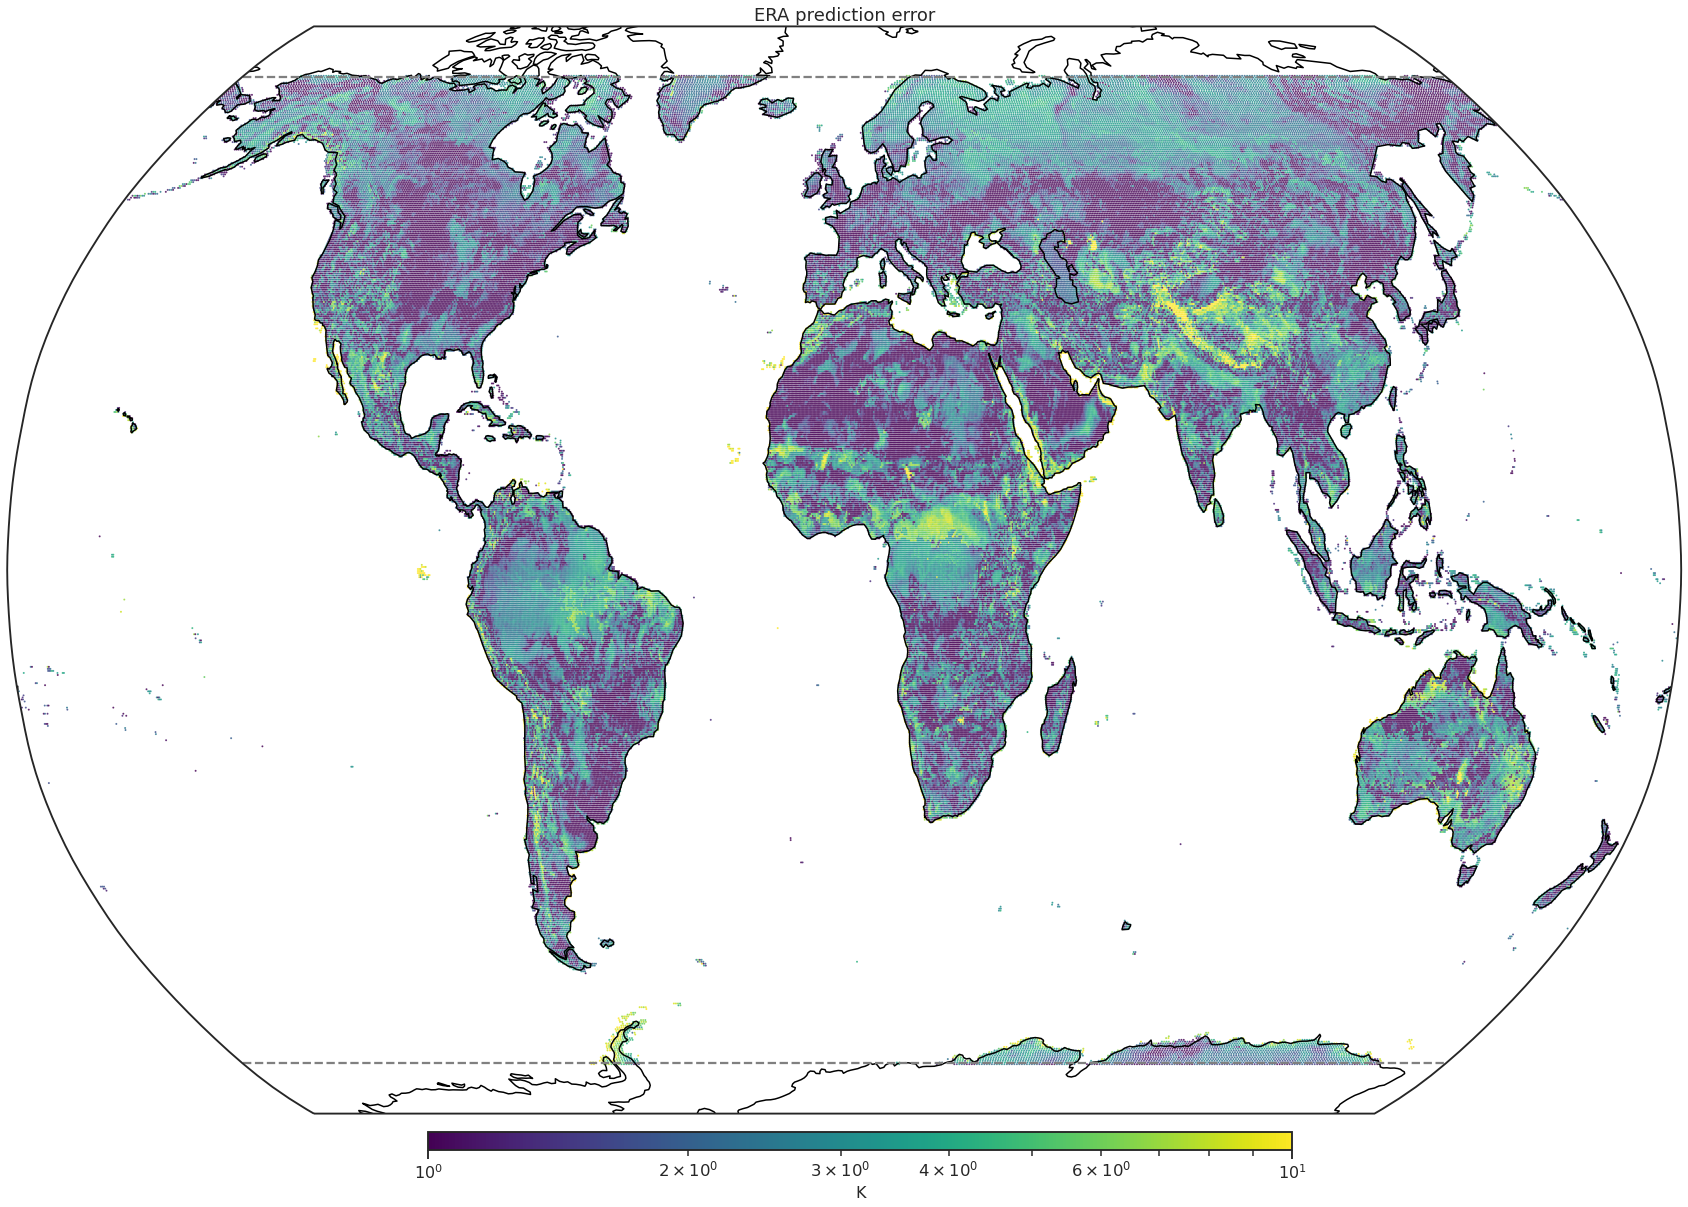

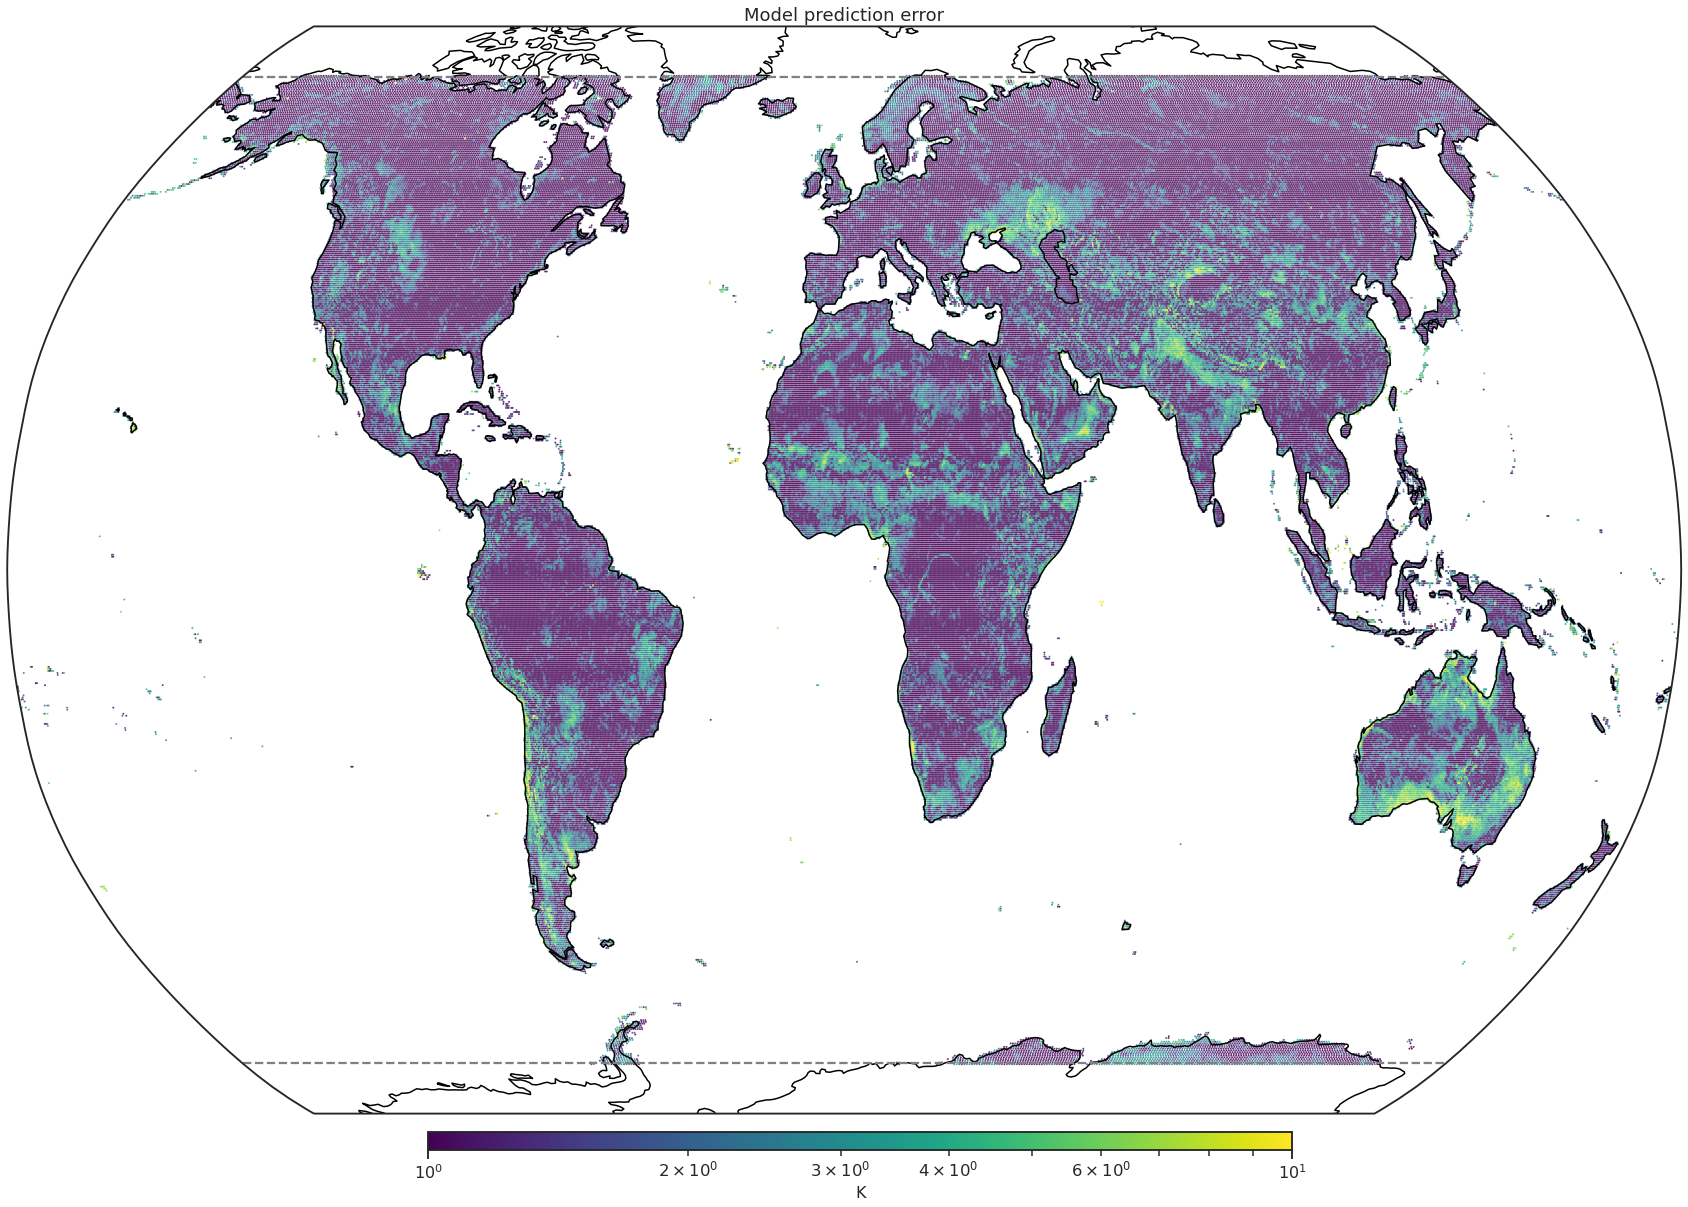

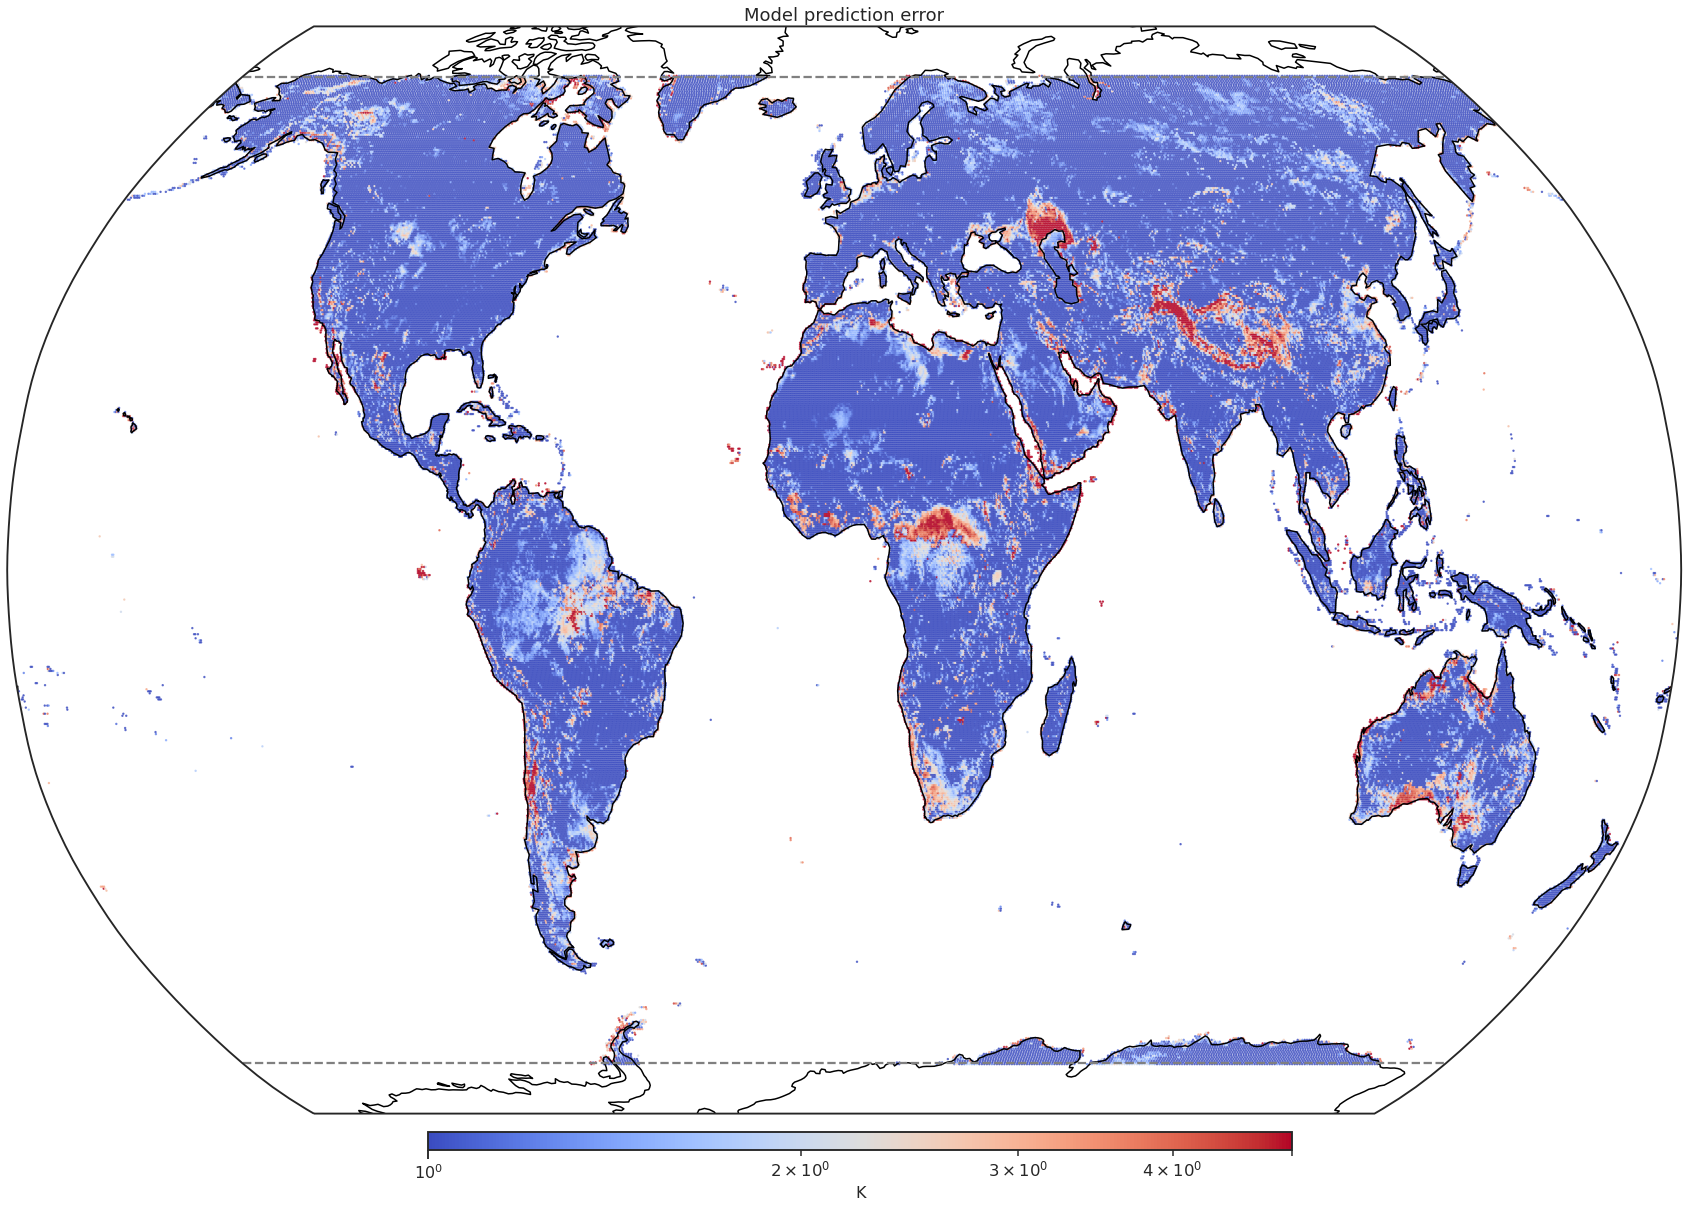

In [18]:
#Same plots on a logscale




global_plot(yearly_averaged_predictions,
            'ERA_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=True,
            title='ERA prediction error',
            markersize=1,
            savefig=None)





global_plot(yearly_averaged_predictions,
            'model_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=True,
            title='Model prediction error',
            markersize=1,
            savefig=None)


global_plot(yearly_averaged_predictions,
            'delta',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=+5,
            cmap=plt.cm.coolwarm,
            absolute_values = True,
            logscale=True,
            title='Model prediction error',
            markersize=2,
            savefig=None)





# Histogram of errors

    


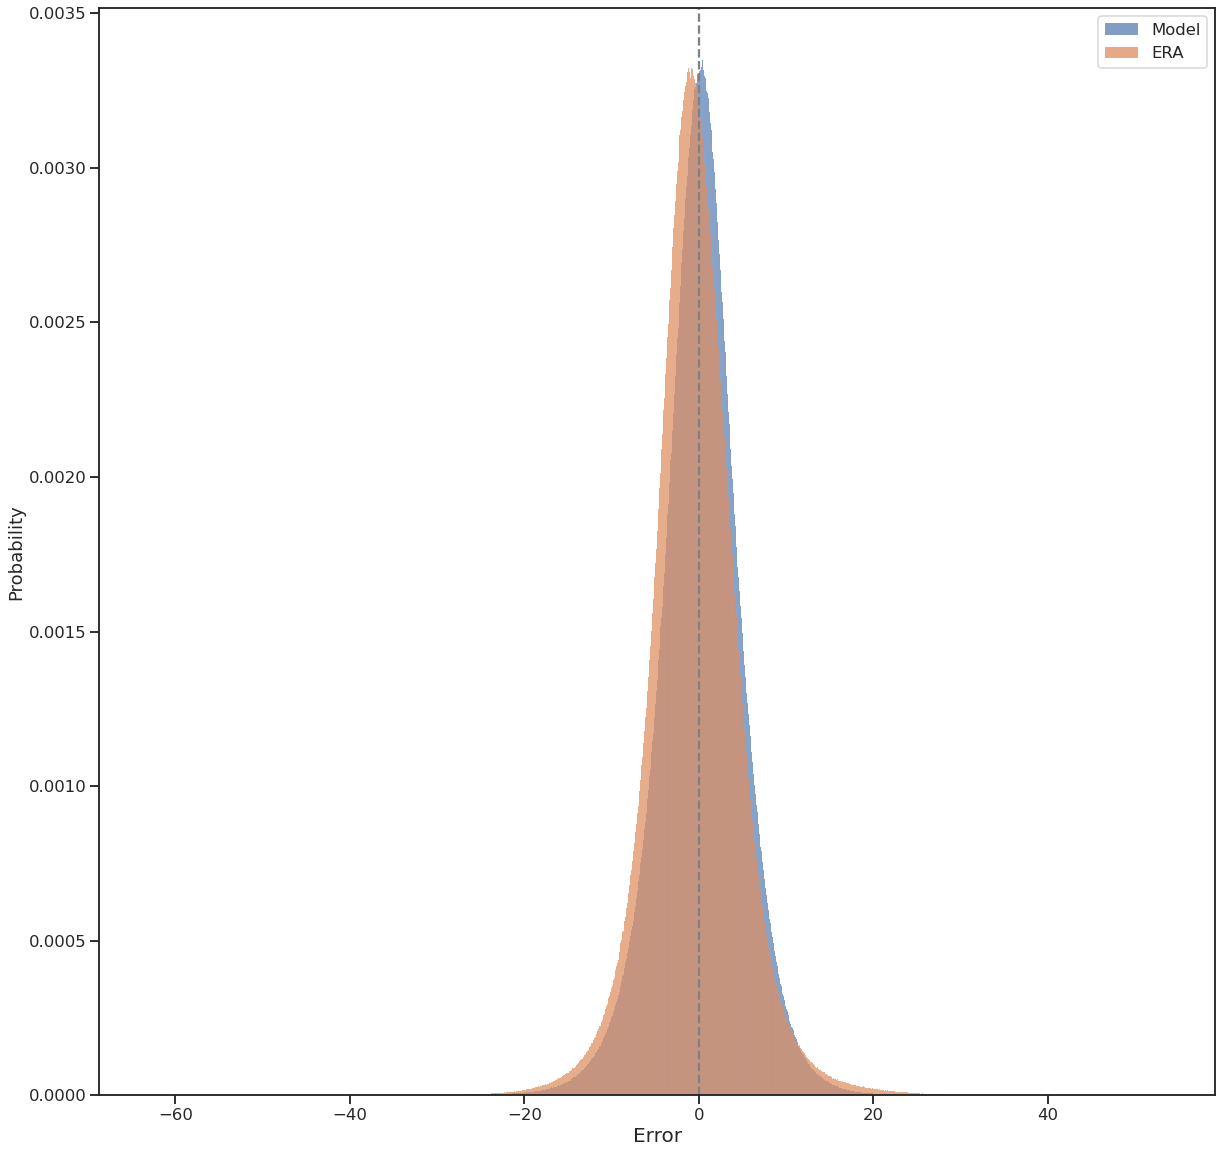

CPU times: user 1min 54s, sys: 6.46 s, total: 2min
Wall time: 2min 3s


In [9]:
%%time


import seaborn as sns
#Plot distribution of errors
#This is quite slow, ~1-2 mins

#Setup plot env
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )


#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))






sns.histplot(predictions['model_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='Model')
sns.histplot(predictions['ERA_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C1',label='ERA')

# Config
ax1.set_xlabel('Error', fontsize = 20)
ax1.legend().set_title(None)
ax1.axvline(0,c='0.5', linestyle='--')




plt.show()


---